# COGS 118A - Project Checkpoint

# Names

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 

- what your goal/problem is
- what the data used represents and how they are measured
- what you will be doing with the data
- how performance/success will be measured


Our goal is to build a model that accurately classfies handwritten digits. This problem is quite useful and is used in automating the process of cashing in/depositing checks. We plan to use the MNIST handwritten dataset, which holds data for more than 70,000 images. With our data, we plan to build a model using the k-NN algorithm introduced in class, and then evaluate the error through a 10x10 confusion matrix representing each digit. Since the dataset is more or less balanced across all the digits, we plan to use accuracy or f1 score as our metric. Additionally, we will be testing the model with different k values to find the optimal value.

Further, we plan to create a basic neural network using the sigmoid function as our activation layer, since it represents probability well (for each datapoint, we will find the prob. it belongs to a certain class, and then choose the max prob). We will have to one hot encode the dataset, then choose an optimizer (probably Adam since it uses adaptive learning rates), and then also a loss function (probably cross entropy). Finally, we will be able to evaluate it the model in the same way as our knn model, and compare the models.

Finally, from the better model, we will create a simliarity metric to evaluate the most similar digits to a given input image. This will be useful because it shows the possible errors that the model may have, and what we should do to prevent them. For example, we can hypothesize that digits 4 and 9 are very similar in nature when we write, so one application in real life is to firmly distinguish them on checks.

# Background

Prior work using this dataset has included deep learning optimization of learning rates, attacks/defenses on adversial training, and large margin classification. In our project, we aim to distiguish the difference between different hyperparameters, including but not limited to speed and accuracy. We test optimizers like rmsprop, adam, and sgd, which are usually variant in speed and generalization but not always (and can also largely depend on the learning rate). This is important for proof of convergence, and dynamic bounds, which in theory are good ideas but need to be tested on simpler, small scale models before being able to be understood and predict how they will react on large scale projects <sup>[1](#adaptivelearningrate)</sup>. In addition, handwritten digits can also be expanded into a broader topic of just handwritten words, and how to classify that. This includes ideas such as encoder/decoder neural networks, which all the parameters build upon the backs of more basic models like our handwritten digit classifiers <sup>[2](#handwritten)</sup>. Since the logic from building ground up is the same, being able to identify which parameters are important to use and how to choose them in our digit classifier is key to success in larger projects.






# Problem Statement

Sometimes, when we pass checks through our banks, receive/send mail using our postal services, or even make an investment, we get errors because of our handwriting. The goal of the project is to develop and compare KNN and neural network models which can both accurately classify the digits in the MNIST dataset to try and understand how models in real life work and what elements are considered when building them. The models will be evaluated based on their accuracy, which will be found as the percentage of correctly classified digits. In order to accurately classify these labels, we will be using some gradient descent which was described in class to minimize our loss. Finally, to prevent these errors in real life, we will create similiarity metrics between images, so when combined with real life context, help understand how to distinguish digits and which digits commonly have errors. Our overall goal includes not only determining the similarity between digits, but also understanding the different hyperparameters used in our model and how to predict results from them in order to tell when they are useful for further projects.

# Data

Our data is the MNIST dataset which can easily downloaded through tensorflow and keras, which is what we are going to use.
Each observation consists of a handwritten digit which can be from 0-9, size 28x28 pixels and 70,000 total images. Here is a link to the [dataset.](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/mnist.py)

We will need to normalize the images, meaning rescaling the pixel values so that they are all consistent. Since we are dealing with images, we can just use the pixels as our range. The max value of a pixel is 255, so if we divide each image by 255, the pixels should all be in the range of 0-1.

Additionally, the dataset is huge. For knn, this means our training is going to take forever, which is why we randomly sampled a subset of images from the train,val,test sections. We plan to adjust this as we go along. 

For the neural network, we probably will take a similar approach in sampling the data, but because it is a different model, the training time will differ. Therefore, we will decide when we implement it.



In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split into train, validation, and test sets
train_split = int(0.75 * len(x_train))
val_split = int(0.25 * len(x_train))

x_val, y_val = x_train[train_split:train_split+val_split], y_train[train_split:train_split+val_split]
x_train, y_train = x_train[:train_split], y_train[:train_split]

# Normalize the input data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Print the shape of the training and testing sets
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

2023-02-22 23:12:02.265542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 23:12:02.436172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 23:12:02.436230: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 23:12:04.999703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Training set shape: (45000, 28, 28) (45000,)
Validation set shape: (15000, 28, 28) (15000,)
Testing set shape: (10000, 28, 28) (10000,)


In [2]:
# convert the matrix into a shape that kNN can work with
def convert_shape(mat):
    n_samples = mat.shape[0]
    n_features = mat.shape[1] * mat.shape[2]
    return mat.reshape(n_samples, n_features)
    

In [3]:
x_train = convert_shape(x_train)
x_val = convert_shape(x_val)
x_test = convert_shape(x_test)
x_train.shape

(45000, 784)

### Sampling
We can see that the dataset is huge. Below we will randomly sample n number of images from the dataset to help speed up the process.

In [4]:
import numpy as np
# Define the number of elements to sample
n = 2000

# Generate random indices
indices = np.random.choice(x_train.shape[0], n, replace=False)

# Sort the indices
indices = np.sort(indices)

# Select the subset of training data using the indices
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

In [5]:
n = 500
# Generate random indices
indices = np.random.choice(x_val.shape[0], n, replace=False)

# Sort the indices
indices = np.sort(indices)

# Select the subset of training data using the indices
x_val_subset = x_val[indices]
y_val_subset = y_val[indices]

In [ ]:
n = 500
# Generate random indices
indices = np.random.choice(x_test.shape[0], n, replace=False)

# Sort the indices
indices = np.sort(indices)

# Select the subset of training data using the indices
x_test_subset = x_test[indices]
y_test_subset = y_test[indices]

# Proposed Solution


Since our training data is plentiful, we will first use k-NN as our benchmark model. Our solution is to convert and normalize the images into feature vectors by flattening the image, and then creating a datastructure for all these vectors so it will be efficient to pull out the labels during the test period. Next, we will have to choose different values of k to tune the hyperparameters, and then choose the best k value based on our evaluation metrics.

Next, for our neural network, we can just use the same data from our knn model as its been preprocessed. Then, we will design the architecture of the model. We will first use adam for our optimizer as well as the sigmoid function as our activation function, since it will represent probability well. For each training point, when we pass through the activation layer we intend to return the probability it belongs to each class, and select the highest. Then, we will compare the predicted label with the true label to see if the loss function is necessary, then finally update the parameters of the model. We will try this model with multiple different parameters to select the best model.

Finally, we will compare both models and evaluate which one performs better. Then, create a cosine or jaccard similarity function that we can run through the model to see which images/digits are the most similar. From this we can identify how to prevent digit errors.

# Evaluation Metrics




When considering evaluation metrics, it is important to understand where the problem is applicable for risk assessment. Most likely, we will be using handwritten classifiers in postal services, investments, and banks. Because of the widespread use in many industries, we believe using the F1 score would be the best evaluation metric for a model. This is because it puts weight on both precision and recall, trying to equally balance the error instead of heavily weighting one side of the error over the other (FP vs FN). In the preliminary results below, we can take a look at our confusion matrix and also get a glimpse of how we plan to use these metrics).

Furthermore, we can also use accuracy as the evaluation metric. Accuracy is a performance metric that measures the proportion of correctly classified examples in the dataset. When we apply accuracy to our MNIST handwritten dataset, the accuracy will give an indication of how well the K-NN model is able to correctly classify the handwritten digits. If we get a high accuracy, it tells us that the model is able to correctly classify most of the digits. If we get a low accuracy, it tells us that the model has difficulty to correctly classify the dights. 

In terms of the f1 score mathematically represented, we just plan to use it how we derived in class, which is (2* Precision *Recall)/(Precision+Recall)

However, in code we could just use the sci-kit learn function.



# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



Accuracy: 0.908


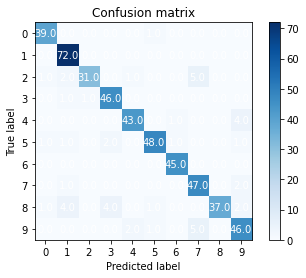

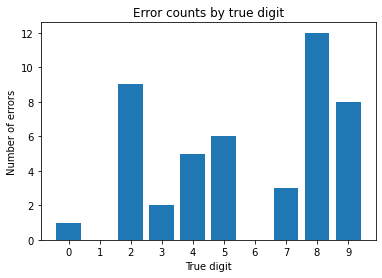

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Create a k-NN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn.fit(x_train_subset, y_train_subset)

# Make predictions on the validation data
y_pred_val = knn.predict(x_val_subset)

# Compute the accuracy of the model
accuracy = accuracy_score(y_val_subset, y_pred_val)
print(f"Accuracy: {accuracy}")

# Compute the confusion matrix and error for each digit
conf_matrix = np.zeros((10, 10))
error_counts = np.zeros(10)
for true_label, pred_label in zip(y_val_subset, y_pred_val):
    conf_matrix[true_label, pred_label] += 1
    if true_label != pred_label:
        error_counts[true_label] += 1
        
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap='Blues')
# Set the axis labels and title
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion matrix')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data and annotate the matrix entries
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='w')

plt.show()


# Plot the error for each digit
fig, ax = plt.subplots()
ax.bar(np.arange(10), error_counts)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_xlabel('True digit')
ax.set_ylabel('Number of errors')
ax.set_title('Error counts by true digit')
plt.show()

### Getting some error metrics

In [8]:
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - TP - FP - FN

array([39., 72., 31., 46., 43., 48., 45., 47., 37., 46.])

In [11]:
FP
# each of the metrics is formatted the same. Each element in the array represents the count of that metric(FP in this case)
# for that digit.

# EX: for digit 0, there are 3 false positives.

array([ 3.,  9.,  1.,  6.,  3.,  3.,  2., 10.,  0.,  9.])

This is our preliminary results, we will improve the knn model through:

Cross-validation: Instead of splitting the data into a single training and testing set, we can use cross-validation to evaluate the model's performance on multiple test sets. This can provide a more robust estimate of the model's accuracy and help to prevent overfitting.

Feature scaling: it is important to ensure that all features contribute equally to the distance calculation. We can use scikit-learn's MinMaxScaler to scale the features to a common range.

Hyperparameter tuning: The k-NN algorithm has a hyperparameter k, which specifies the number of neighbors to consider when making a prediction. The optimal value of k can depend on the specific dataset and problem, so it's a good idea to tune this parameter using techniques such as grid search or randomized search.

Distance metric: The choice of distance metric can also have a significant impact on the performance of the k-NN algorithm. By default, scikit-learn uses the Euclidean distance metric, but other metrics such as Manhattan distance or cosine distance may be more appropriate for certain problems.

In our confusion matrix, we can see the number of correctly classified images for each digits, as well as a bar graph to better represent. From our basic model, digits 2 and 8 seems to produce the most errors, while 1 is the most accurate digit.

These are all things that we will implement in our knn model, before we design the neural network.


# Ethics & Privacy


One ethical concern we have with the MNIST dataset is the potential of bias within the dataset. What we mean by this is that there may be more samples of a certain digit compared to the rest, resulting in poor performance in that digit. Further, the intention of building this model using the MNIST dataset is to expand it to real applications, such as banks. With an architecture/evaluation metric that doesn't put weight on false positives, this could be lead to really catastrophic errors in the banking industry. For example, misidentifying a 4 or 9 can be a large difference, especially if it's a number like 400000 to 90000.

We plan to address this issue of bias by testing different model parameters such as data augmentation as well as changing the sampling strategy. For the other concern, we plan to use metrics that put weight on false postivies, including precision and f1 score. Then, we will use similarity metrics to actually see which digits are the most prone to these mistakes to allow this knowledge to be more widespread.

# Team Expectations 


* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic KNN model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/17  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (Xinyao/Yingnan)  | Assign group members to lead each specific part   |
| 2/18  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 2/18  | 12 PM  | Improve knn w/different parameters, explain changes (Yingnan) | Discuss/edit project code; Complete project |
| 2/25  | 12 PM  | Complete analysis; Draft results/conclusion/discussion (Xinyao)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes

<a name="adaptivelearningrate">1</a>: Luo, Liangchen (2019) Adaptive Gradient Methods with Dynamic Bound of Learning Rate. *ICLR 2019*. https://paperswithcode.com/paper/adaptive-gradient-methods-with-dynamic-bound<br> 

<a name="handwritten">2</a>: Matcha, Anil. 22 August 2022. How to easily do Handwriting Recognition using Machine Learning. *Nanonets*. https://nanonets.com/blog/handwritten-character-recognition/<br> 